In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize  import fsolve

from dataclasses import dataclass
from typing import Callable

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab

# Настройка свойств графиков "по умолчанию"
params = {'legend.fontsize': 13, 'figure.figsize': (9, 5), 'axes.labelsize': 13,
         'axes.titlesize':13, 'xtick.labelsize':12,'ytick.labelsize':13}
pylab.rcParams.update(params)

Параметры системы

In [82]:
@dataclass
class Data:
    # Гравитационный параметр Луны
    mu : float = 4890.0e9;
    # Радиус Луны
    Rm : float = 0.5*3476e3;
    # Начальная масса 
    m : float =  2000    
    # Зависимость тяги от времени
    F : Callable[[float], float] = lambda t: 0
    # Максимальная тяга
    Fmax : float = 20e3
    # Удельный импульс
    Isp : float = 3500

# Создаем экземпляр класса Data (объект)
p = Data()

Функция правых частей системы дифференциальных уравнений движения посадочного модуля в центральном гравитационном поле Луны под действием силы тяги двигателя, направленной в противоположном направлении вектора скорости модуля

In [83]:
def dqdt(t, q, p):  
    r  = q[0:3]
    v  = q[3:6]
    # Израсходовано топлива
    mf = q[6]
    # Модуль скорости
    vnorm = np.linalg.norm(v)
    # Направлени вектора скорости
    ev = v/vnorm
    # Текущая масса модуля
    mass = p.m - mf
    # Ускорение
    a = - p.mu*r/(np.linalg.norm(r)**3) - ev*p.F(t)/mass
    # Секундный расход
    dm = np.abs(p.F(t))/p.Isp
    return np.hstack([v,a,dm])

Функция-"детектор", передаваемая в интегратор (параметр events), для определения времени достижения заданной радиальной скорости vk и остановки процесса интегрирования  

In [84]:
def event_hv(t, q, p, vk):      
    r = np.linalg.norm(q[0:3])
    h = r - p.Rm
    er = q[0:3]/r
    vr = np.dot(q[3:6],er);
    return vr-vk

Функция определяет высоту, на которой вертикальная скорость становится равной заданному значению vk

In [85]:
def get_he_v_eq_0(h0, p, vk):
    R0  = p.Rm+h0;
    V0  = np.sqrt(p.mu/R0);
    q0  = np.array([R0,0,0, 0,V0,0.0, 0.0]);
    Tk  = 1000;        
    ev = lambda t,q: event_hv(t,q,p,vk)
    ev.direction = 1
    ev.terminal  = True    
    sol = solve_ivp(lambda t,q: dqdt(t,q,p), [0,210], q0, method='RK45', events = [ev,], rtol = 1e-8)
    he   = np.sqrt(np.sum(sol.y[0:3]**2,axis=0))-p.Rm
    return he[-1]

In [86]:
p.F = lambda t: p.Fmax
h1 = fsolve(lambda x: get_he_v_eq_0(x[0], p, -1.0)-100.0, [10000.0])[0]

In [87]:
h1

3520.4339950604244

In [88]:
R0  = p.Rm+h1;
V0  = np.sqrt(p.mu/R0);
q0  = np.array([R0,0,0, 0,V0,0.0, 0.0]);
Tk  = 1000;        
ev = lambda t,q: event_hv(t,q,p,-1.0)
ev.direction = 1
ev.terminal  = True    
sol = solve_ivp(lambda t,q: dqdt(t,q,p), [0,210], q0, method='RK45', events = [ev,], rtol = 1e-8)

Построим графики изменения высоты и скорости на первом этапе спуска.

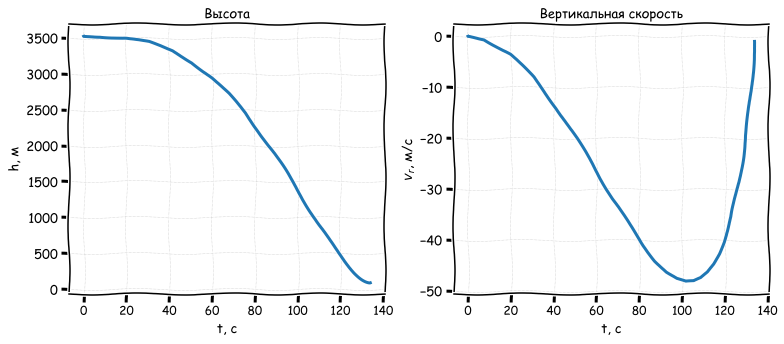

In [89]:
height   = np.sqrt(np.sum(sol.y[0:3]**2,0))-p.Rm
velocity = np.sqrt(np.sum(sol.y[3:6]**2,0))
er = sol.y[0:3].transpose()/np.repeat(np.sqrt(np.sum(sol.y[0:3].transpose()**2,axis=1)),3).reshape(-1,3)
velocity = np.sum(er*sol.y[3:6].transpose(),axis=1)

with plt.xkcd():
    plt.figure(figsize=[11,5])
    plt.subplot(1,2,1)
    plt.plot(sol.t,height,lw=3)
    plt.xlabel('t, c')
    plt.ylabel('h, м')
    plt.grid(True, lw=0.5, zorder=0,ls=':')
    plt.title('Высота');

    plt.subplot(1,2,2)
    plt.plot(sol.t,velocity,lw=3)
    plt.xlabel('t, c')
    plt.ylabel('$v_r$, м/c')
    plt.grid(True, lw=0.5, zorder=0,ls=':')
    plt.title('Вертикальная скорость');
    
    plt.tight_layout()    
    plt.savefig('moon-lander-fig-stage2.png',dpi=300)

### Этап 2

Второй этап состоит из двух участков:
- участок свободного падения
- участок работы двигателя

Предполагается, что посадочный модуль движется вертикально и движение происходит в однородном гравитационном поле

In [90]:

h2 = (np.sqrt(np.sum(sol.y[0:3]**2,0))-p.Rm)[-1];
v2 = -1.0
Vk = 0;
b  = abs(p.Fmax)/p.Isp;
# Ускорение свободного падения (постоянное)
g  = p.mu/p.Rm**2;
# Масса посадочного модуля на момент окончания первого активного участка
m2 = p.m-sol.y[6][-1]

f1 = lambda tp,ta: v2-g*(ta+tp)-p.Isp*np.log((m2-b*ta)/m2)-Vk;
f2 = lambda tp,ta: h2+v2*(ta+tp)-g/2*(ta+tp)**2-p.Isp*((ta-m2/b)*(np.log(1-b/m2*ta)-1)-m2/b);
f  = lambda x: (f1(x[0],x[1]), f2(x[0],x[1]));

t23e = fsolve(f,[1,1])
print('Начальная высота                     {:3.1f} м'.format(h2))
print('Продолжительность свободного падения {:3.1f} c'.format(t23e[0]))
print('Продолжительность торможения         {:3.1f} c'.format(t23e[1]))

Начальная высота                     100.0 м
Продолжительность свободного падения 9.9 c
Продолжительность торможения         1.2 c


In [91]:
t0  = sol.t[-1];
q0  = sol.y[:,-1];
te  = t23e[0]+t23e[1];        
p.F = lambda t: (t>t0+t23e[0])*p.Fmax
sol2 = solve_ivp(lambda t,q: dqdt(t,q,p), [t0,t0+te], q0, method='BDF', rtol = 1e-8)

In [92]:
r  = np.sqrt(np.sum(sol2.y[0:3]**2,0))
h  = r-p.Rm
v  = np.sqrt(np.sum(sol2.y[3:6]**2,0))
er = sol2.y[0:3].transpose()/np.repeat(r,3).reshape(-1,3)
vr = np.sum(er*sol2.y[3:6].transpose(),axis=1)

#### Графики

Построим графики изменения высоты и скорости посадочного модуля на втором этапе движения

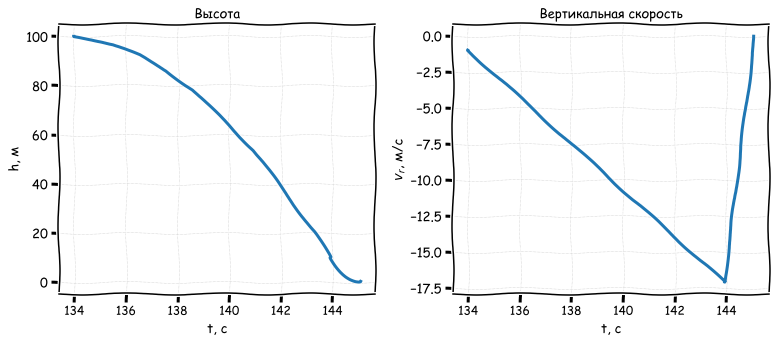

In [93]:
with plt.xkcd():
    plt.figure(figsize=[11,5])
    plt.subplot(1,2,1)
    plt.plot(sol2.t,h,lw=3)
    plt.xlabel('t, c')
    plt.ylabel('h, м')
    plt.grid(True, lw=0.5, zorder=0,ls=':')
    plt.title('Высота');

    plt.subplot(1,2,2)
    plt.plot(sol2.t,vr,lw=3)
    plt.xlabel('t, с')
    plt.ylabel('$v_r$, м/с')
    plt.grid(True, lw=0.5, zorder=0,ls=':')
    plt.title('Вертикальная скорость');
    plt.tight_layout()    
    plt.savefig('moon-lander-fig-stage34.png',dpi=300)

В свободном падении с высоты 100 м с начальной скоростью 1 м/с посадочный модуль до запуска двигателя достигает скорости более 15 м/с.  

Суммарный топлива (без учета гомановского перехода с опорной орбиты):

In [45]:
sol2.y[6,-1]

1158.4144930820034